In [1]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "classification"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

Scikit-Learn provides many helper functions to download popular datasets. MNIST is one of them. The following code fetches the __MNIST__ dataset from "OpenML.org":

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', as_frame=False)   # dataset contains images, and DataFrames aren't ideal for that, so it's preferable to set as_frame = False
                                                    # to get the data as NumPy arrays instead

In [3]:
mnist.DESCR

"**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  \n**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  \n**Please cite**:  \n\nThe MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  \n\nIt is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 

In [4]:
mnist.keys()    # we will only use data and target

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

Look at these arrays:

In [5]:
X, y = mnist.data, mnist.target
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(70000, 784))

In [6]:
X.shape

(70000, 784)

In [7]:
y

array(['5', '0', '4', ..., '4', '5', '6'], shape=(70000,), dtype=object)

In [8]:
y.shape

(70000,)

To see the picture, we have to grab an instance's feature vector, reshape it to a 28 X 28 array, and display it using Matplotib's `imshow()` function.
#
Use `cmap="binary"` to get a grayscale color map where 0 is white and 255 is black.

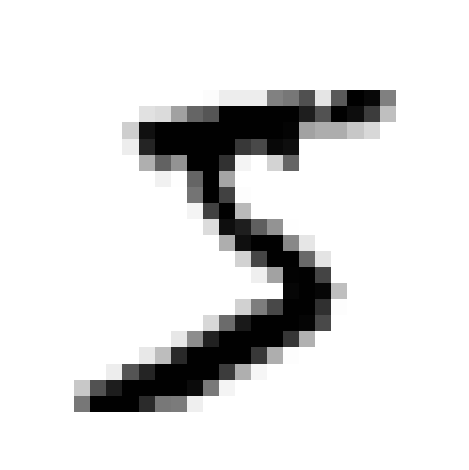

In [9]:
import matplotlib.pyplot as plt

def plot_digit(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")

some_digit = X[0]
plot_digit(some_digit)
save_fig("some_digit_plot")
plt.show()      # this looks like 5

In [10]:
# what the lable tells us:
y[0]

'5'

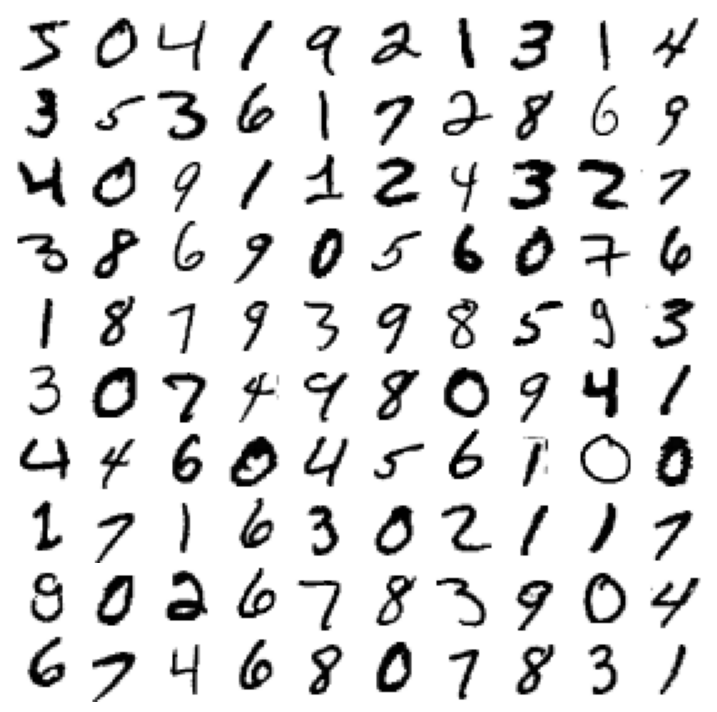

In [11]:
plt.figure(figsize=(9, 9))
for idx, image_data in enumerate(X[:100]):
    plt.subplot(10, 10, idx + 1)
    plot_digit(image_data)
plt.subplots_adjust(wspace=0, hspace=0)
save_fig("more_digits_plot", tight_layout=False)
plt.show()

We should always create a test set and set it aside before inspecting the data closely.
#
The original MNIST dataset is classically organized as:
- 60,000 training images
- 10,000 test images
#
- The training set is already shuffled for us, which is good because this guarantees that all cross-validation folds will be similar.
- Moreover, some learning algorithms are sensitive to the order of the training instances, and they perform poorly if they get many similar instances in a row.
- Shuffling the datasets ensures that this won't happen.

> Datasets returned by `fetch_openml()` are not always shuffled or split.

In [12]:
# to match the original MNIST split:
X_train, X_test = X[:60000], X[60000:]
y_train, y_test = y[:60000], y[60000:]

## Training a Binary Classifier
For now we only try to identify one digit - for example, the number 5.
This "5-detector" will be an example of a _binary classfier_, capable of distinguishing between just two classes, 5 and non-5

In [13]:
# creating the target vectors for this classification task:
y_train_5 = (y_train == '5')  # True for all 5s, False for all other digits
y_test_5 = (y_test == '5')

### Pick a classifier and train it.
We will use - _stochastic gradient descent_ (SGD) classifier using Scikit-Learn's __SGDClassifier__ class.
- This classifier is capable of handling very large datasets efficiently.
- SGD deals with training instances independently, one at a time, which also makes SGD well suited for online learning.

In [14]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [15]:
# now we can use it to detect images of the number 5
sgd_clf.predict([some_digit])

array([ True])

This classifier guesses that this image represents a 5 (True). Looks like it guessed right in this particular case! Now, let's evaluate this model's performance.

## Performance Measures
Evaluating a classifier is often significantly trickier than evaluating a regressor. There are many performance measures available, so we'll learn a bunch of new concepts and acronyms!

### Measuring Accuracy Using Cross-Validation

In [16]:
# k-fold cross-validation

from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

Wow! Above 95% accuracy (ratio of correct predictions) on all cross-validation folds? Looks amazing, well let's look at a dummy classifier that just classifies every single image in the most frequent class, which in this case is the negative class (i.e., non 5)

In [17]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_5)
print(any(dummy_clf.predict(X_train)))  # no 5s detected

False


In [18]:
# model accuracy
cross_val_score(dummy_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.90965, 0.90965, 0.90965])

It has over 90% accuracy! This is simply because only about 10% of the images are 5s, so if we always guess that an image is not a 5, we will be right about 90% of the time.

This demonstrates why accuracy is generally not the preferred performance measure for classifiers, especially when we are dealing with _skewed datasets_ (when some classes are much more frequent than others).

A much better way to evaluate the performance of a classifier is to look at the _confusion matrix_ (CM).

In [19]:
## Implementing Cross-Validation Manually to have more control over the process

''' 
Occasionally we will need more control over the cross-validation process than what Scikit-Learn provides off the shelf.
In these cases, we can implement cross-validation ourselves. 
This code does roughly the same thing as Scikit-Learn's cross_val_score() function, and it prints the same result:
'''
''' 
The StratifiedKFold class performs stratified sampling to produce folds that contain a representative ratio of each class.
At each iteration the code creates a clone of the classifier, trains that clone on the training folds, 
and makes predictions on the test fold.
Then it counts the number of correct predictions and outputs the ratio of correct predictions.
'''

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3)  # add shuffle=True if the dataset is not
                                       # already shuffled
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

# in plain language
# -> split the data into 3 parts
# -> for each part:
#     -> train the model on the other 2 parts
#     -> test it on this part 
#     -> print the accuracy
# -> we get 3 accuracy scores --- one for each fold


0.95035
0.96035
0.9604


### Confusion Matrix
- The general idea of a confusion matrix is to count the number of times instances of class A are classified as class B, for all A/B pairs.
- For example, to know the number of times the classifier confused images of 8s with 0s, we would look at row #8, column #0 of the confusion matrix.
- To compute the confusion matrix, we first need to have a set of predictions so that they can be compared to the actual targets.

In [20]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

# cross_val_predict() performs k-fold cross-validation, but instead of returning the evaluation scores,
# it returns the predictions made on each test fold.
# this means that we get a clean prediction for each instance in the training set
# by "clean" means "out-of-sample": the model makes predictions on data that it never saw during training

Now we are ready to get the confusion matrix using the `confusion_matrix()` function.

In [21]:
from sklearn.metrics import confusion_matrix

# just pass it the target (y_train_5) and the predicted class (y_train_pred)
cm = confusion_matrix(y_train_5, y_train_pred)
cm

array([[53892,   687],
       [ 1891,  3530]])

- Each row in a confusion matrix represents an actual class, while each column represents a predicted class.

- The first row of this matrix considers non-5 images (the negative class): 53,892 of them were correctly classified as non-5s (they are called _true negatives_), while the remaining 687 were wrongly classified as 5s (false positives, also called _type 1 errors_).

- The second row considers the images of 5s (_the positive class_): 1,891 were wrongly classified as non-5s (_false negatives_, also called _type 2 errors_), while the remaining 3,530 were correctly classified as 5s (_true positives_).

- A perfect classifier would only have true positives and true negatives, so its confusion matrix would have nonzero values only on its main diagonal (top left to bottom right):

In [22]:
y_train_perfect_predictions = y_train_5     # pretend we reached perfection
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

The confusion matrix gives us a lot of information, but sometimes we may prefer a more concise metric.
# 
An interesting one to look at is the accuracy of the positive predictions; this is called the ___precision___ of the classifier
$$
\text{Precision} = \frac{TP}{TP + FP}
$$

Where:

* **TP** = True Positives (correct "yes" predictions)
* **FP** = False Positives (wrong "yes" predictions)


- A trivial way to have perfect precision is to create a classifier that always makes negative predictions, except for one single positive prediction on the instance it's most confident about.
- If this one prediction is correct, then the classifier has 100% precision ( precision = 1/1 = 100%),
- Such a classifier would not very useful, since it would ignore all but one positive instance.
- So, precision is typically used along with another metric named _recall_, also called _sensitivity_ or the _true positive rate_ (TPR): this is the ratio of positive instances that are correctly detected by the classifier.
$$
\text{recall} = \frac{TP}{TP + FN}
$$
_FN_ is, of course, the number of false negatives.

### Precision and Recall

In [23]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)    # == 3530 / (687 + 3530)

0.8370879772350012

In [24]:
# this cell also computes the precision: TP / (FP + TP)
cm[1, 1] / (cm[0, 1] + cm[1, 1])

np.float64(0.8370879772350012)

In [25]:
recall_score(y_train_5, y_train_pred)  # == 3530 / (1891 + 3530)

0.6511713705958311

Our 5-detector does not look as shiny as it did when we looked at its accuracy. <br>
When it claims an image represents a 5, it is correct only 83.7% of the time. Moreover, it only detects 65.1% of the 5s.

It is convenient to combine precision and recall into a single metric called the $ F_1 $ score, especially when we need a single metric to compare two classifiers. The $ F_1 $ score is the harmonic mean of precision and recall.
# 
Whereas the regular mean treats all values equally, the harmonic mean gives much more weight to low values. <br>
As a result, the classifier will only get a high $ F_1 $ score if both recall and precision are high.

In [26]:
# to compute the F1 score, simply call the f1_score() function
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343847

The $ F_1 $ score favors classifiers that have similar precision and recall. This is not always what we want: in some context we mostly care about precision, and in other contexts we really care about recall.
- Example: 
    - if we trained a classifier to detect videos that are safe for kids, we would probably prefer a classifier that rejects many good videos (low recall) but keeps only safe ones (high precision), rather than a classifier that has a much higher recall but lets a few really bad videos show up in our product (in such cases, we may even want to add a human pipeline to check the classifier's video selection).
    
    - suppose we train a classifier to detect shoplifters in surveillance images: it is probably fine if our classifier only has 30% precision as long as it has 99% recall (sure, the security guards will get a few false alerts, but almost all shoplifters will get caught).

Unfortunately, we can't have it both ways: increasing precision reduces recall, and vice versa. This is called the _precision/recall trade-off._

### The Precision/Recall Trade-off


To understand this trade-off, look at how the SGDClassifier makes its classification decisions. For each instance, it computes a score based on a _decision function_. If that score is greater than a threshold, it assigns the instance to the positive class; otherwise it assigns it to the negative class.
#
Scikit-Learn does not let us set the threshold directly, but it does give us access to the decision scores that it uses to make predictions.<br>
Instead of calling the classifier's `predict()` method, we can call its `decision_function()` method, which returns a score for each instance, and then use any threshold we want to make predictions based on those scores:

In [27]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [28]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

The __SGDClassifier__ uses a threshold equal to 0, so the preceding code returns the same result as the `predict()` method (i.e., True). Let's raise the threshold:

In [29]:
threshold = 3000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

This confirms that raising the threshold decreases recall. The image actually represents a 5, and the classifier detects it when the threshold is 0, but it misses it when the threshold is increased to 3,000.
##### How to decide which threshold to use?
First, use the `cross_val_predict()` function to get the scores of all instances in the training set, but this time specify that we want to return decision scores instead of predictions:

In [30]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

With these scores, use the `precision_recall_curve()` function to compute precision and recall for all possible thresholds (the function adds a last precision of 0 and a last recall of 1, corresponding to an infinite threshold):

In [31]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

Finally, use Matplotlib to plot precision and recall as functions of the threshold value. Let's show the threshold of 3,000 we selected:

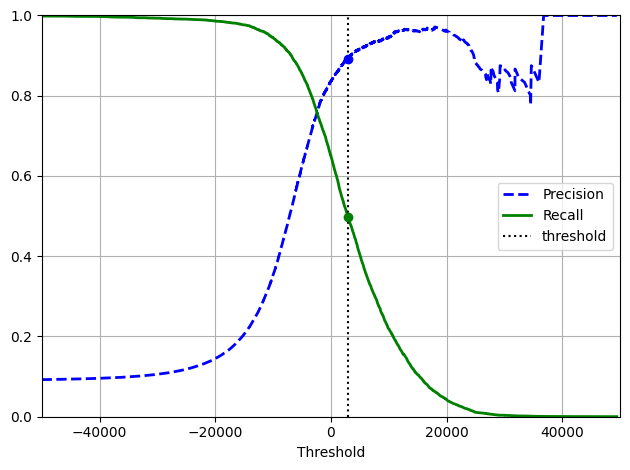

In [32]:
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold")

# beautifies
idx = (thresholds >= threshold).argmax()  # first index ≥ threshold
plt.plot(thresholds[idx], precisions[idx], "bo")
plt.plot(thresholds[idx], recalls[idx], "go")
plt.axis([-50000, 50000, 0, 1])
plt.grid()
plt.xlabel("Threshold")
plt.legend(loc="center right")
save_fig("precision_recall_vs_threshold_plot")

plt.show()

At this threshold value, precision is near 90% and recall is around 50%. Another way to select a good precision/recall trade-off is to plot precision directly against recall, as shown here:

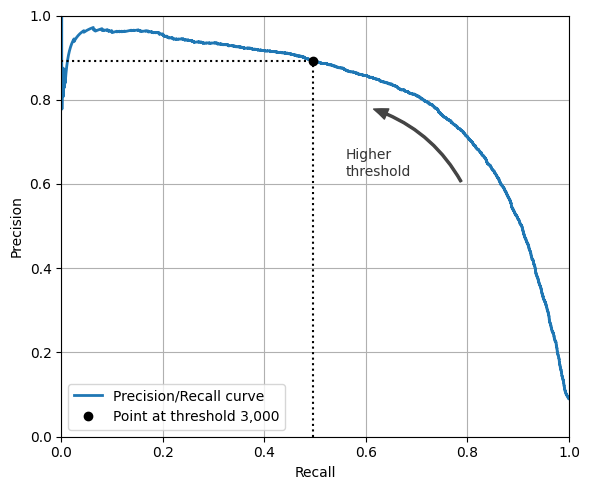

In [33]:
import matplotlib.patches as patches  #  – for the curved arrow

plt.figure(figsize=(6, 5))  # – not needed, just formatting

plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")

# beautifies 
plt.plot([recalls[idx], recalls[idx]], [0., precisions[idx]], "k:")
plt.plot([0.0, recalls[idx]], [precisions[idx], precisions[idx]], "k:")
plt.plot([recalls[idx]], [precisions[idx]], "ko",
         label="Point at threshold 3,000")
plt.gca().add_patch(patches.FancyArrowPatch(
    (0.79, 0.60), (0.61, 0.78),
    connectionstyle="arc3,rad=.2",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.56, 0.62, "Higher\nthreshold", color="#333333")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")
save_fig("precision_vs_recall_plot")

plt.show()

We can see that precision really starts to fall sharply at around 80% recall. We will probably want to select a precision/recall trade-off just before that drop -- for example, at around 60% recall. But of course, the choice depends on our project.
#
Suppose we decide to aim for 90% precision. We could use the first plot to find the threshold we need to use, but that's not very precise. Alternatively, we can search for the threshold that gives us at least 90% precision. For this, we can use the NumPy's array's `argmax()` method. This returns the first index of the maximum value, which in this case means the first True value:

In [34]:
idx_for_90_precision = (precisions >= 0.90).argmax()
threshold_for_90_precision = thresholds[idx_for_90_precision]
threshold_for_90_precision

np.float64(3370.0194991439557)

To make predictions (on the training set for now), instead of calling the classifier's `predict()` method, we can run this code:

In [35]:
y_train_pred_90 = (y_scores >= threshold_for_90_precision)

# let's check these predictions' precision and recall
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [36]:
recall_at_90_precision = recall_score(y_train_5, y_train_pred_90)
recall_at_90_precision

0.4799852425751706

Now we have a 90% precision classifier! As we see, it is fairly easy to create a classifier with virtually any precision we want: just set a high enough threshold, and we're done. But a high-precision classifier is not very useful if its recall is too low! For many applications, 48% recall wouldn't be great at all.

> If someone says, "Let's reach 99% precision", we should ask, "At what recall?"

### The ROC Curve
The _receiver operating characteristic_ (ROC) curve is another common tool used with binary classifiers. It is very similar to the precision/recall curve, but instead of plotting precision verses recall, the ROC curve plots the _true positive rate_ (another name for recall) against the _false positive rate_ (FPR). The FPR (also called _fall-out_) is the ratio of negative instances that are incorrectly classified as positive. It is equal to 1 - the _true negative rate_ (TNR), which is the ratio of negative instances that are correctly classified as negative. The TNR is also called _specificity_. Hence, the ROC curve plots _senstivity_ (recall) versus 1 - _specificity_.

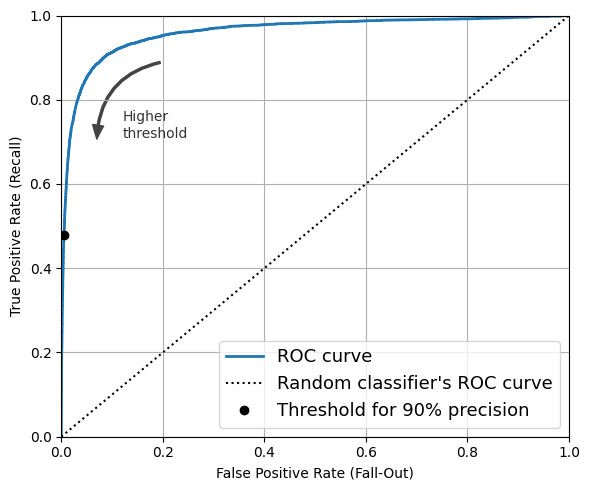

In [37]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

# To find the point that corresponds to 90% precision, we need to look for the index of the desired threshold.
# Thresholds are listed in decreasing order in this case

idx_for_threshold_at_90 = (thresholds <= threshold_for_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]

plt.figure(figsize=(6, 5))  # just formatting
plt.plot(fpr, tpr, linewidth=2, label="ROC curve")
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")
plt.plot([fpr_90], [tpr_90], "ko", label="Threshold for 90% precision")

# just beautifies 
plt.gca().add_patch(patches.FancyArrowPatch(
    (0.20, 0.89), (0.07, 0.70),
    connectionstyle="arc3,rad=.4",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.12, 0.71, "Higher\nthreshold", color="#333333")
plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.grid()
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower right", fontsize=13)
save_fig("roc_curve_plot")

plt.show()

- Once again there is a trade-off: the higher the recall (TPR), the more false positives (FPR) the classifier produces.
- The dotted line represents the ROC curve of a purely random classifier; a good classifier stays as far away from the line as possible (toward the top-left corner).
#
One way to compare classifiers is to measure the _area under the curve_ (AUC). A perfect classifier will have a ROC AUC equal to 1, whereas a purely random classifier will have a ROC AUC equal to 0.5.

In [38]:
# Scikit-learn provides a function to estimate the ROC AUC:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

np.float64(0.9604938554008616)

Read pr-vs-roc.md

Let's now create a RandomForestClassifier, whose PR curve and $ F_1 $ score we can compare to those of the SGDClassifier:

In [39]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)

- The `precision_recall_curve()` function expects labels and scores for each instance, so we need to train the random forest classifier and make it assign a score to each instance.
- But the RandomForestClassifier class does not have a `decision_function()` method, due to the way it works we will do this later.
- It has a `predict_proba()` method that returns class probabilities for each instance, and we can just use the probability of the positive class as a score, so it will work fine.
- We can still call the `cross_val_predict()` function to train the RandomForestClassifier using cross-validation and make it predict class probabilities for every image as follows:

> Scikit-Learn classifiers always have either a decision_function() method or a predict_proba() method, or sometimes both.

In [40]:
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

In [41]:
y_probas_forest[:2]

array([[0.11, 0.89],
       [0.99, 0.01]])

The model predicts that the first image is positive with 89% probability, and it predicts that the second image is negative with 99% probability. Since each image is either positive or negative, the probabilities in each row add up to 100%. These are _estimated_ probabilities, not actual probabilities.

The second column contains the estimated probabilities for the positive class, so let's pass them to the `precision_recall_curve()` function:

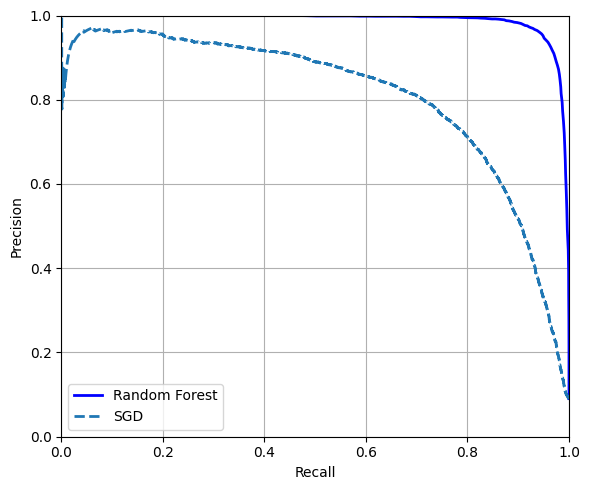

In [42]:
y_scores_forest = y_probas_forest[:, 1]
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(y_train_5, y_scores_forest)

# now we're ready to plot the PR curve. It is useful to plot the first PR curve as well to see how they compare

plt.figure(figsize=(6, 5))  

plt.plot(recalls_forest, precisions_forest, "b-", linewidth=2,
         label="Random Forest")
plt.plot(recalls, precisions, "--", linewidth=2, label="SGD")

# beautifies
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")
save_fig("pr_curve_comparison_plot")

plt.show()

The random forest classifier is superior to the SGD classifier beacuse its PR curve is much closer to the top-right corner. Its $ F_1 $ score and ROC AUC score are also significantly better.

In [43]:
y_train_pred_forest = y_probas_forest[:, 1] >= 0.5  # positive proba ≥ 50%
f1_score(y_train_5, y_train_pred_forest)

0.9274509803921569

In [44]:
roc_auc_score(y_train_5, y_scores_forest)

np.float64(0.9983436731328145)

In [45]:
precision_score(y_train_5, y_train_pred_forest)

0.9897468089558485

In [46]:
recall_score(y_train_5, y_train_pred_forest)

0.8725327430363402

Now we know how to train binary classifiers, choose the appropriate metric for our task, evaluate our classifiers using cross-validation, select the precision/recall trade-off that fits our needs, and use several metrics and curves to compare various models. We're ready to try to detect more than just the 5s.

## Multiclass Classification
Whereas binary classifiers distinguish between two classes, _multiclass classifiers_ (also called _multinomial classifiers_) can distinguish between more than two classes.
#
Some Scikit-Learn classifiers (e.g., LogisticRegression, RandomForestClassifier, and GaussianNB) are capable of handling multiple classes natively. Others are strictly binary classifiers (e.g., SGDClassifier and SVC). However, there are various strategies that we can use to perform multiclass classification with multiple binary classifiers.

### Strategy
- One way to create a system that can classify the digit images into 10 classes (from 0 to 9) is to train 10 binary classifiers, one for each digit. Then when we want to classifiy an image, we get the decision score for each classifier for that image and we select the class whose classifier outputs the highest score. This is called _one-versus-the-rest_ (OvR) strategy, or sometimes _one-versus-all (OvA).

- Another way is to train a binary classifier for every pair of digits: one to distinguish 0s and 1s, another to distinguish 0s and 2s, another for 1s and 2s, and so on. This is called _one-versus-all_ (OvO) strategy. If there are _N_ classes, we need to train $ N * (N - 1) / 2 $ classifiers. For the MNIST problem, this means training 45 binary classifiers! When we want to classify an image, we have to run the image through all 45 classifiers and see which class wins the most duels. The main advantage of OvO is that each classifier only needs to be trained on the part of the training set containing the two classes that it must distinguish.

#
Some algorithms (such as support vector machine classifiers) scale poorly with the size of the training set. For these algorithms OvO is preferred because it is faster to train many classifiers on small training sets than to train few classifiers on large training set. For most binary classification algorithms however, OvR is preferred.
#
Scikit-Learn detects when we try to use a binary classification algorithm for a multiclass classification task, and it automatically runs OvR or OvO, depending on the algorithm. Let's try this with a support machine classifier using the `sklearn.svm.SVC` class.

In [48]:
from sklearn.svm import SVC

svm_clf = SVC(random_state=42)
# we will only train on the first 2000 images or else it will take a very long time
svm_clf.fit(X_train[:2000], y_train[:2000])  # y_train, not y_train_5

SVC(random_state=42)

We trained the SVC using the original target classes from 0 to 9 (y_train), instead of the 5-versus-the-rest target classes (y_train_5). Since there are 10 classes (i.e., more than 2), Scikit-Learn used the OvO strategy and trained 45 binary classifiers.

In [49]:
# now let's make a prediction
svm_clf.predict([some_digit])

array(['5'], dtype=object)

That's correct! This code actually made 45 predictions - one per pair of classes - and it selected the class that won the most duels. If we call the `decision_function()` method, we will see that it returns 10 scores per instance: one per class. Each class gets a score equal to the number of won duels plus or minus a small tweak (max +_0.33) to break ties, based on the classifier scores:

In [50]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores.round(2)

array([[ 3.79,  0.73,  6.06,  8.3 , -0.29,  9.3 ,  1.75,  2.77,  7.21,
         4.82]])

The highest score is 9.3, and it's indeed the one corresponding to class 5:

In [51]:
class_id = some_digit_scores.argmax()
class_id

np.int64(5)

When a classifier is trained, it stores the list of target classes in its classes_ attribute, ordered by value. In the case of MNIST, the index of each classes_ array conveniently matchs the class itself (e.g., the class at index 5 happens to be class '5'), but in general we won't be so lucky; we will need to look up the class label like this:

In [52]:
svm_clf.classes_

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object)

In [56]:
svm_clf.classes_[class_id]

'5'

If you want decision_function() to return all 45 scores, you can set the decision_function_shape hyperparameter to "ovo". The default value is "ovr", but don't let this confuse you: SVC always uses OvO for training. This hyperparameter only affects whether or not the 45 scores get aggregated or not:

In [57]:
# shows how to get all 45 OvO scores if needed
svm_clf.decision_function_shape = "ovo"
some_digit_scores_ovo = svm_clf.decision_function([some_digit])
some_digit_scores_ovo.round(2)

array([[ 0.11, -0.21, -0.97,  0.51, -1.01,  0.19,  0.09, -0.31, -0.04,
        -0.45, -1.28,  0.25, -1.01, -0.13, -0.32, -0.9 , -0.36, -0.93,
         0.79, -1.  ,  0.45,  0.24, -0.24,  0.25,  1.54, -0.77,  1.11,
         1.13,  1.04,  1.2 , -1.42, -0.53, -0.45, -0.99, -0.95,  1.21,
         1.  ,  1.  ,  1.08, -0.02, -0.67, -0.14, -0.3 , -0.13,  0.25]])

If we want to force Scikit-Learn to use one-versus-one or one-versus-the-rest, we can use the OneVsOneClassifier or OneVsRestClassifier classes. Simply create an instance and pass a classifier to its constructor (it doesn't even have to be a binary classifier). For example, this code creates a multiclass classifier using the OvR strategy, based on the SVC:

In [53]:
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC(random_state=42))
ovr_clf.fit(X_train[:2000], y_train[:2000])

OneVsRestClassifier(estimator=SVC(random_state=42))

Let's make a prediciton, and check the number of trained classifiers:

In [54]:
ovr_clf.predict([some_digit])

array(['5'], dtype='<U1')

In [58]:
len(ovr_clf.estimators_)

10

Training an SGDClassifier on a multiclass dataset and using it to make predictions is just as easy:

In [59]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array(['3'], dtype='<U1')

That's incorrect. Prediction errors do happen! This time Scikit-Learn used the OvR strategy under the hood: since there are 10 classes, it trained 10 binary classifiers. The `decision_function()` method now returns one value per clas. Let's look at the scores that the SGD classifier assigned to each class:

In [60]:
sgd_clf.decision_function([some_digit]).round()

array([[-31893., -34420.,  -9531.,   1824., -22320.,  -1386., -26189.,
        -16148.,  -4604., -12051.]])

We can see that the classifier is not very confident about its predictions: almost all scores are very negative, while class 3 has a score of +1824, and class 5 is not too far behind at -1,386. Of course, we'll want to evaluate this classifier on more than one image. Since there are roughly the same number of images in each class, the accuracy metric is fine. As usual, we can use the `cross_val_score()` function to evaluate the model:

In [61]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.87365, 0.85835, 0.8689 ])

It gets over 85.8% on all test folds. If we used a random classifier, we would get 10% accuracy, so this is not such a bad score, but we can still do much better. Simply scaling the inputs increases accuracy above 89.1%:

In [63]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype("float64"))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])